# SubScript Leaderboard Explorer

1. Explore the leaderboard data
2. Use clustering to determine the core users of the service based on their activity
3. Find out which activities are most salient for each cluster

## Dependencies and Defaults

In [1]:
import config
import pandas as pd
import numpy as np
import os

In [2]:
dir_home = config.home_dir
dir_clean = config.clean_dir
dir_raw = config.raw_dir
f_in = 'leaderboard_stats.csv'
f_dfa = 'dataforazeroth_complete_dataset.csv'
path_in = os.path.join(dir_clean, f_in)
path_in2 = os.path.join(dir_raw, f_dfa)

## Clean Leaderboard Player Data

In [3]:
df_ps = pd.read_csv(path_in) # Load in the leaderboard_player_stats
df_dfa = pd.read_csv(path_in2) # load in the leaderboard_stats
df_ps['id'] = str(df_ps.index.values) + '_' + df_ps.player + '_' + df_ps.realm
df_dfa['id'] = ''
df_dfa['id'] = str(df_dfa.index.values) + '_' + df_dfa.player + '_' + df_dfa.realm 
df_ps = df_ps.fillna(0) # NA is equivalent to 0 for all columns (player has not attempted or completed)
for index,row in df_dfa.iterrows(): # Format player and realm with lowercase and no special chars
    if isinstance(row.player, str):
        df_dfa.at[index,'player'] = row.player.lower()
    if isinstance(row.realm, str):
        df_dfa.at[index,'realm'] = row.realm.replace('US-', '').replace("'", '').lower()
        df_dfa.at[index,'id'] = df_dfa.loc[index,'player'] + '_' + df_dfa.loc[index,'realm']

In [4]:
df_dfa = df_dfa.set_index('id')
df_ps['leaderboard'] = ''
for index, row in df_ps.iterrows(): # Add leaderboards to player stats
    df_ps.at[index, 'leaderboard'] = df_dfa[df_dfa.index == row.id].leaderboard.values

In [5]:
cols = [col for col in df_ps.columns if 'Unnamed' not in col] # Remove unnamed columns (former indexes)
df_ps = df_ps[cols]

## Describe the Leaderboard Player Stats Dataframe

In [6]:
df_ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15983 entries, 0 to 15982
Columns: 5148 entries, 10 to leaderboard
dtypes: float64(5140), object(8)
memory usage: 627.8+ MB


In [7]:
df_ps.describe()

,10,10000,10001,10010,10011,10012,10013,10015,10016,10017,...,9998,completed_quests,guild_rank,honor_level,level,mounts_collected,pets_collected,realm_id,total_achievement_points,total_achievements
count,15983.000000,15983.0,15983.0,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,...,15983.0,15983.000000,1.598300e+04,15983.000000,15983.000000,15983.000000,15983.000000,15983.0,15983.000000,15983.000000
mean,0.994557,0.0,0.0,0.850716,0.848839,0.643684,0.749296,0.365764,0.416943,0.715135,...,0.0,6423.620096,1.319898e+08,136.499030,118.252080,488.479384,1073.709754,0.0,26060.873115,2997.514734
std,0.073580,0.0,0.0,0.356379,0.358217,0.478925,0.433432,0.481659,0.493069,0.451364,...,0.0,3617.390640,5.395812e+07,126.389915,10.918314,154.108984,447.911069,0.0,5920.919793,706.624994
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,1.818800e+04,0.000000,10.000000,0.000000,0.000000,0.0,2695.000000,349.000000
25%,1.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,3000.000000,1.068713e+08,40.000000,120.000000,393.000000,746.500000,0.0,22290.000000,2537.000000
50%,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.0,7425.000000,1.390488e+08,105.000000,120.000000,532.000000,1215.000000,0.0,27490.000000,3152.000000
75%,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,9850.000000,1.744264e+08,192.000000,120.000000,605.000000,1379.000000,0.0,31055.000000,3593.000000
max,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,10938.000000,2.126883e+08,1139.000000,120.000000,718.000000,2018.000000,0.0,33585.000000,4033.000000


## DBSCAN Clustering

#### Remove non-numeric columns 

In [8]:
str_cols = ['leaderboard','level', 'guild_rank','player', 'id', 'realm', 'realm_id', 'playable_race', 'playable_class', 'faction', 'guild_name']
try:
    df_dbscan = df_ps.drop(str_cols, axis = 1)
except:
    pass

In [9]:
df_dbscan

,10,10000,10001,10010,10011,10012,10013,10015,10016,10017,...,9995,9996,9997,9998,completed_quests,honor_level,mounts_collected,pets_collected,total_achievement_points,total_achievements
0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,10508.0,177.0,586.0,1191.0,30155.0,3460.0
1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,10523.0,106.0,542.0,1210.0,28515.0,3315.0
2,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,10513.0,119.0,572.0,1170.0,31175.0,3579.0
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,10512.0,233.0,626.0,1781.0,32875.0,3796.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,10566.0,20.0,529.0,1521.0,29365.0,3247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15978,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,8250.0,73.0,412.0,1352.0,25335.0,2872.0
15979,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,8821.0,210.0,392.0,1364.0,19390.0,2158.0
15980,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,7464.0,43.0,417.0,1273.0,22395.0,2579.0
15981,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,9724.0,139.0,642.0,1258.0,31185.0,3584.0


#### Run the DBSCAN clustering

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=4, min_samples=10).fit(df_dbscan)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(n_clusters_)


0


#### Print the results of the clustering

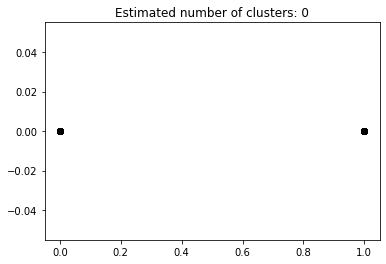

In [11]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_dbscan[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df_dbscan[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Did not work because of binary data

Categorizaing data first based on achievement categories

#### Trying again with only a few non-categorical columns

In [12]:
df_dbscan2 = df_ps[['completed_quests','honor_level','level','mounts_collected','pets_collected','total_achievement_points','total_achievements']]

#Normalizing the data
df_dbscan2.completed_quests = df_dbscan2.completed_quests.div(1000)
df_dbscan2.honor_level = df_dbscan2.honor_level.div(100)
df_dbscan2.mounts_collected = df_dbscan2.mounts_collected.div(100)
df_dbscan2.pets_collected = df_dbscan2.pets_collected.div(1000)
df_dbscan2.total_achievement_points = df_dbscan2.total_achievement_points.div(10000) 
df_dbscan2.total_achievements = df_dbscan2.total_achievements.div(1000)

/Users/haleyspeed/Docs/insight/ins_env/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=5, min_samples=50).fit(df_dbscan2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(n_clusters_)


2


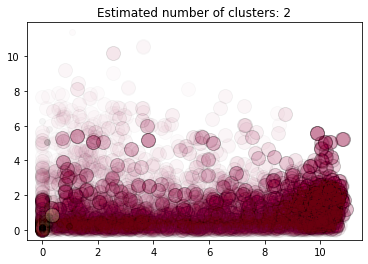

In [14]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_dbscan2[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, alpha = 0.02)

    xy = df_dbscan2[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, alpha = 0.02)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Sort of two groups but not what we're looking for

## Transform leaderboard player stats reducing dataset to categories

#### Make a new dataframe with categories instead of individual achievements

In [77]:
import custom_funcs as cf


# base_cols contains leaderboard player stats columns without achievements
base_cols = ['leaderboard','level', 'guild_rank','player', 'id', 'realm', 'realm_id', 
        'playable_race', 'playable_class', 'faction', 'guild_name', 'completed_quests',
        'honor_level','mounts_collected','pets_collected','total_achievement_points',
        'total_achievements']

# import a list of achievement categories
df_cat = pd.read_csv(os.path.join(dir_raw, 'wow_achievement_categories.csv'))
achieve_cols = base_cols + list(df_cat.id.values.astype(int).astype(str))

# Make a new, empty dataframe with player info and achievement categories
df_ps_cat = pd.DataFrame(columns = achieve_cols)

#### Get category for each achievement

In [78]:
ach_ids = df_ps.columns.difference(base_cols)
df_ach = pd.DataFrame()

for ach in ach_ids:
    results = cf.get_wow_achievement(ach)
    
    if not isinstance(results, str):
        print(results)
        df_ach = df_ach.append(results, ignore_index = True)
    print(ach, end = ' ')

{'achievement_name': 'Level 50', 'achievement_id': 10, 'category_name': 'Character', 'category_id': 92, 'criteria_id': 2053, 'criteria_name': 'Reach level 50.', 'next_name': 'Level 60', 'next_id': 11}
10 10000 10001 {'achievement_name': 'Gate of the Setting Sun', 'achievement_id': 10010, 'category_name': 'Pandaria Dungeon', 'category_id': 15106, 'criteria_id': 43685, 'criteria_name': 'Gate of the Setting Sun (Raigonn)', 'next_name': 'Heroic: Gate of the Setting Sun', 'next_id': 6759}
10010 {'achievement_name': 'Siege of Niuzao Temple', 'achievement_id': 10011, 'category_name': 'Pandaria Dungeon', 'category_id': 15106, 'criteria_id': 43688, 'criteria_name': "Siege of Niuzao Temple (Wing Leader Ner'onok)", 'next_name': 'Heroic: Siege of Niuzao Temple', 'next_id': 6763}
10011 

In [79]:
print(df_ach.achievement_id.head())

0       10.0
1    10010.0
2    10011.0
Name: achievement_id, dtype: float64


In [80]:
df_ach.category_id = df_ach.category_id.astype(int).astype(str)
df_ach.achievement_id = df_ach.achievement_id.astype(int).astype(str)
df_ach.to_csv(os.path.join(dir_clean, 'achievement_details_list.csv'))


#### Go through leaderboard player stats and tally achievements by category

In [84]:
#for col in df_ps_cat.columns:
    #print(col, end = "':,'")
i = 0    
for index, row in df_ps.iterrows():
    tmp = pd.DataFrame(columns = achieve_cols) ### Achieve cols should be nubers
    print(i, end = ' ')
    for col, value in row.iteritems():
        print (col, end = ' ')
        category_id = df_ach.loc[df_ach.achievement_id == col].category_id.values[0]
        tmp[category_id] = tmp[category_id] + 1
    df_ps_cat = df_ps_cat.append(tmp, ignore_index = True)
    i = i +1

0 10 92
10000 

IndexError: index 0 is out of bounds for axis 0 with size 0